<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction à la Recherche Opérationelle</h1><br/>M2 Statistique Science des Données (SSD)</center></td>
<td width=15%>
<a href="https://www-ljk.imag.fr/membres/Anatoli.Iouditski/" style="font-size: 16px; font-weight: bold">Anatoli Juditsky</a><br/>
<a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a><br/></td>
</tr>
</table>

<br/><br/>
<center><a style="font-size: 30pt; font-weight: bold">TP 1 - Planification de Regime </a></center>
<br/><br/>

# 1- Récupération des données

## Menu

In [186]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from itertools import product

In [2]:
foods = pd.read_csv("data/food.dat",sep='\t')
n,p = foods.shape 

In [113]:
def find_n_best_samples(list: np.array, sortorder: np.array, n: int):
    return list[sortorder][-n:]

def pretty_print_results(status: str, x: Optional[np.array], L: float, n_samples: int=5):
    print("Status:", status)

    if x is not None:
        fig, ax = plt.subplots()

        sorted = np.argsort(x)
        selected = find_n_best_samples(x, sorted, n_samples)
        ax.bar(list(map(lambda label: label if len(label) < 8 else label[:6]+'..', find_n_best_samples(foods["Food"].values, sorted, n_samples))), selected)
        ax.tick_params(axis='x', labelrotation=80)

        fig.suptitle(f"{n_samples} most represented food items")
        plt.show()
    else:
        print(f"Convergence issues, L(x*)={L}")

Le tableau `foods` contient tous les aliments présent à la carte d'un restaurant avec leurs informations nutritionelles.

In [3]:
foods

,Food,Cal,CalFat,Fat,SatFat,Chol,Sodium,Carbo,Protein,VitA,VitC,Calcium,Iron
0,1%_Low_Fat_Milk_Jug 1_carton_(236_ml) ...,100,20,2,1,10,125,12,8,10,4,30,0
1,Apple_Slices 1.2_oz_(34_g) ...,15,0,0,0,0,0,4,0,0,160,2,0
2,BBQ_Ranch_Burger 4.1_oz_(116_g) ...,350,140,16,6,45,680,37,16,4,0,20,15
3,"Bacon,_Egg_&_Cheese_Bagel 7_oz_(199_g) ...",630,290,32,11,275,1490,57,30,20,15,20,20
4,"Bacon,_Egg_&_Cheese_Bagel_with_Egg_Whites 7.2_...",580,230,26,9,60,1490,55,30,10,15,20,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Vanilla_McCafe_Shake_(12_fl_oz_cup) 12_fl_oz ...,530,140,15,10,60,160,86,11,20,0,40,0
301,Vanilla_McCafe_Shake_(16_fl_oz_cup) 16_fl_oz ...,660,170,19,12,75,200,109,14,25,0,50,0
302,Vanilla_McCafe_Shake_(22_fl_oz_cup) 22_fl_oz ...,820,210,23,15,90,260,135,18,30,0,60,0
303,Vanilla_Reduced_Fat_Ice_Cream_Cone 3.7_oz_(105...,170,40,4,3,15,70,27,5,6,0,15,2


In [4]:
n

305

## Alimentation idéale en termes de nutriments

In [5]:
nutr = pd.read_csv("data/nutr_ideal.dat",sep=' ')

La tableau `nutr` contient les valeurs pour une alimentation *optimale* en terme de nutriments.

In [6]:
nutr

,CalFat,Fat,SatFat,Chol,Sodium,Carbo,Protein,VitA,VitC,Calcium,Iron
0,600,65,20,300,2400,300,50,100,100,100,100


# 2- Trouver un régime optimal

## Combinaisons pour une alimentation pauvre en calories

Pour commencer, nous allons essayer de trouver une combinaison $x\in\mathbb{R}^n$ des aliments ($x_i$ correspondant à la quantité d'aliment $i$ prise) qui minimise le total de calories sous contrainte de rester idéal vis à vis des *nutriments* (CalFat, Fat, VitA, etc.)

> **Question:** Formaliser et résoudre le problème décrit ci-dessus. Qu'observez-vous sur la solution?

* Fonction objective linéaire à minimiser: $c^\mathrm{T}x$ où $c$ contient les calories par aliment

In [7]:
c = foods["Cal"].values
print(f"Shape of c vector: {c.shape=}")

Shape of c vector: c.shape=(305,)


In [12]:
def make_linear_loss(calories: np.array, n: int):
    """
    Returns the loss L(x), and its variable x, as cvxpy objects.
    """
    assert n == calories.shape[0], "Please correct the shape of the calories vector c"
    x = cp.Variable(n) # One food item amount by food type
    c = calories.squeeze()
    L = c.T @ x
    return L, x

In [13]:
def solve_simple_linear_pbm(calories: np.array, n: int):
    """
    The problem is to minimize c@x, no constraints yet
    Returns:
        * The solver's final state
        * The problem's sol° x*
        * The loss final value L(x*)
    """
    L, x = make_linear_loss(calories, n)
    obj = cp.Minimize(L)
    prob = cp.Problem(obj)
    prob.solve()
    return prob.status, x.value, prob.value

In [44]:
pretty_print_results(*solve_simple_linear_pbm(c, n))

Status: unbounded
Convergence issues, L(x*)=-inf


<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        The problem is "unbounded". $\vec{x}$ contains $\texttt{None}$, and $\mathcal{L}(\vec{x})$ diverged to $-\infty$.
        It means that we <b>lack some constraints</b>!
    </p>
</div>

* Contrainte à vérifier: $x$ est positif (par de quantités négatives d'aliments) et $Ax=b$ où $A$ contient les valeurs des nutriments par aliment et $b$ contient les valeurs idéales

In [20]:
A = foods.iloc[:, 2:].values.T
b = nutr.values.squeeze()

In [30]:
def def_positivity_contraint(x: cp.Variable):
    constraint = (x >= 0)
    return constraint

def def_naive_constraints(x: cp.Variable, nutrients: np.array, recomendations: np.array):
    """
    Builds the two constraints x>=0 and Ax=b 
    """
    A = nutrients
    b = recomendations
    assert A.shape[0] == b.shape[0] and A.shape[1] == x.shape[0] 

    constraint1 = def_positivity_contraint(x)
    constraint2 = (A @ x == b)
    return [constraint1, constraint2]

* Resolution par CVXPY

Attention, utilisez le Solver "ECOS" 

        prob.solve(verbose=True,solver="ECOS")
        
le solveur par défaut peut donner de fausses informations...

In [31]:
def solve_naive_constraint_pbm(calories: np.array, n: int, nutrients: np.array, recomendations: np.array):
    """
    The problem is to minimize c@x, s.t. x>=0, Ax=b
    Returns:
        * The solver's final state
        * The problem's sol° x*
        * The loss final value L(x*)
    """
    L, x = make_linear_loss(calories, n)
    obj = cp.Minimize(L)

    constraints = def_naive_constraints(x, nutrients, recomendations)
    prob = cp.Problem(obj, constraints=constraints)
    prob.solve(solver="ECOS")
    return prob.status, x.value, prob.value

In [45]:
pretty_print_results(*solve_naive_constraint_pbm(c, n, A, b))

Status: infeasible
Convergence issues, L(x*)=inf


<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        The problem is "infeasible". $\vec{x}$ contains $\texttt{None}$, and $\mathcal{L}(\vec{x})$ diverged to $+\infty$.
        It means that <b>the constraints are too harsh</b>!
    </p>
</div>

## Relaxation des contraintes


Le problème précedent n'avait pas de point faisable avec les contraintes imposées. Afin d'obtenir des points faisable, nous allons remplacer la contrainte
$$ Ax = b$$ 
par les deux contraintes de type *boite*
$$ Ax \geq 0.8 b ~~ \text{ et  } ~~ Ax \leq b $$
ainsi les contraintes de nutriments sont satisfaites entre 80 et 100% et le problème devient faisable.

> **Question:** Définir les deux contraintes de boite et resoudre le problème. Vérifier qu'il est faisable.

In [153]:
def def_box_constraints(x: cp.Variable, nutrients: np.array, recomendations: np.array, percentages: tuple[float, float]=(.8, 1.)):
    """
    Builds the three constraints x>=0, Ax>=(80%)b, Ax<=(100%)b
    """
    A = nutrients
    b = recomendations
    assert A.shape[0] == b.shape[0] and A.shape[1] == x.shape[0]
    low_bound, high_bound = percentages

    constraint1 = def_positivity_contraint(x)
    constraint2 = (A @ x >= low_bound * b)
    constraint3 = (A @ x <= high_bound * b)
    return [constraint1, constraint2, constraint3]

def solve_box_constraints_pbm(calories: np.array, n: int, nutrients: np.array, recomendations: np.array, percentages: tuple[float, float]=(.8, 1.)):
    """
    The problem is to minimize c@x, s.t. x>=0, Ax>=(80%)b, Ax<=(100%)b
    Returns:
        * The solver's final state
        * The problem's sol° x*
        * The loss final value L(x*)
    """
    L, x = make_linear_loss(calories, n)
    obj = cp.Minimize(L)

    constraints = def_box_constraints(x, nutrients, recomendations, percentages)
    prob = cp.Problem(obj, constraints=constraints)
    prob.solve(solver="ECOS")
    return prob.status, x.value, prob.value

In [104]:
results = solve_box_constraints_pbm(c, n, A, b)

In [105]:
print(f"Feasible ? -- {results[0]}")

Feasible ? -- optimal


> **Question:** Affichez les valeur des nutriments pour la solution obtenue et la comparer à 80% et 100% des valeurs prescrites.

Status: optimal


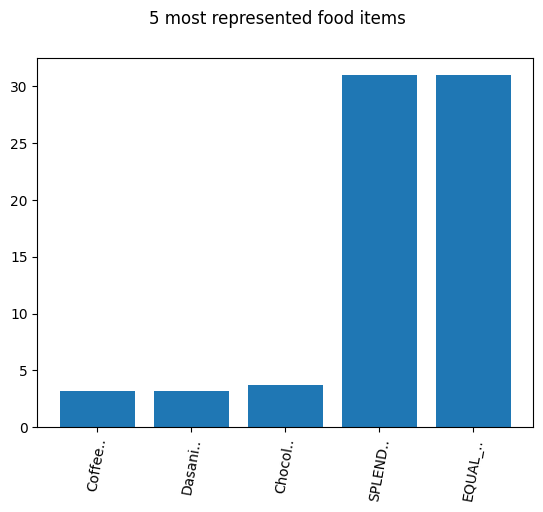

In [114]:
pretty_print_results(*results)

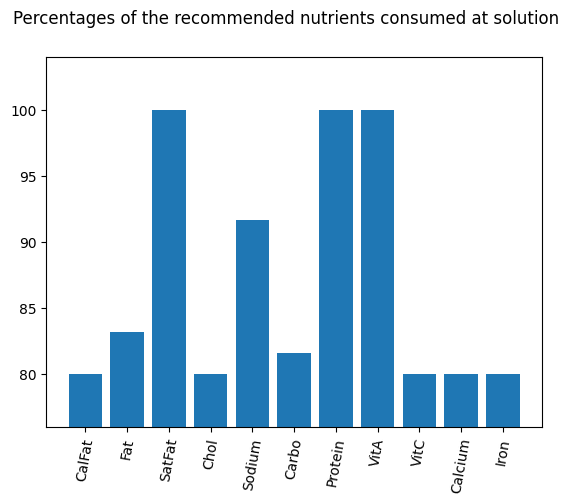

In [119]:
fig, ax = plt.subplots()
ax.bar(nutr.columns, A @ results[1] / b * 100)
ax.tick_params(axis='x', labelrotation=80)
fig.suptitle("Percentages of the recommended nutrients consumed at solution")
ax.set_ylim([76, 104])
plt.show()

> **Question:** Donner le nombre de calories totales et les aliments pour lesquels la quantité est supérieure à 0.3.

In [137]:
print(f"Calories totales: {results[2]}")
print("Food of qty > 0.3:")
for item, res, cals in zip(foods['Food'][results[1] >= 0.3], results[1][results[1] >= 0.3], c[results[1] >= 0.3]):
    print(f"  * {item} for ~{res:.2f} items, at {cals} Cals/item, hence ~{res*cals:.2f} Cals")

Calories totales: 1397.0487147820577
Food of qty > 0.3:
  * Chocolate_Chip_Cookie 1_cookie_(33_g)                      for ~3.69 items, at 160 Cals/item, hence ~590.89 Cals
  * Coffee_(Large) 16_fl_oz_cup                                for ~3.21 items, at 0 Cals/item, hence ~0.00 Cals
  * Coffee_(Medium) 16_fl_oz_cup                               for ~3.21 items, at 0 Cals/item, hence ~0.00 Cals
  * Coffee_(Small) 12_fl_oz_cup                                for ~3.21 items, at 0 Cals/item, hence ~0.00 Cals
  * Dasani_Water 16.9_fl_oz                                    for ~3.21 items, at 0 Cals/item, hence ~0.00 Cals
  * Diet_Coke_(Child) 12_fl_oz_cup                             for ~1.58 items, at 0 Cals/item, hence ~0.00 Cals
  * Diet_Coke_(Large) 30_fl_oz_cup                             for ~1.24 items, at 0 Cals/item, hence ~0.00 Cals
  * Diet_Coke_(Medium) 21_fl_oz_cup                            for ~1.46 items, at 0 Cals/item, hence ~0.00 Cals
  * Diet_Coke_(Small) 16_fl_oz_cup  

On remarque que la solution n'est pas pratique! 

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        Indeed the $\vec{x}$ vector bets everything on diet cokes, coffee/tea, sweeteners ("édulcorants"), regardless of the caffein for example. Hence we need to add clever constraints.
    </p>
</div>

## D'autres contraintes

On va imposer:
* pas de `EQUAL_0_Calorie_Sweetener 1_pkg_(1.0_g)` (item $73$) ni de `SPLENDA_No_Calorie_Sweetener 1_pkg_(1.0_g) :  30.9360336697206` (item $248$)  car c'est pas très bon
* pas plus de 10 unités dans le menu, pas plus de 2 unités par item
* au moins un petit déjeuner (items 3 à 22)

Relacher au besoin les contraintes de nutrition...

> **Question :** Implémenter ces contraintes une par une et regarder la valeur optimale de la fonction (le nombre de calories). Cette valeur augmente-t-elle ou diminue-t-elle ? Pourquoi ?

In [154]:
def def_new_constraints(x: cp.Variable, nutrients: np.array, recomendations: np.array, percentages: tuple[float, float]=(.7, 1.3)):
    """
    Builds more constraints:
        * no pure sweeteners type of meals (eww)
        * no more than 10 units of meal
        * no more than 2 units per meal (i.e. no all-in on one meal)
        * a breakfast containing at least one full unit between all breakfast items
    """
    constraints123 = def_box_constraints(x, nutrients, recomendations, percentages)
    constraint4 = (x[248] == 0.) # "pas de EQUAL_0_Calorie_Sweetener 1_pkg_(1.0_g)"
    constraint5 = (x[73] == 0.) # "ni de SPLENDA_No_Calorie_Sweetener 1_pkg_(1.0_g)"
    constraint6 = (cp.sum(x) <= 10.) # "pas plus de 10 unités dans le menu"
    constraint7 = (x <= 2.) # "pas plus de 2 unités par item"
    constraint8 = (cp.sum(x[3:23]) >= 1.) # "au moins un petit déjeuner (items 3 à 22)"
    return [*constraints123, constraint4, constraint5, constraint6, constraint7, constraint8]

In [148]:
def solve_full_constraints_pbm(calories: np.array, n: int, nutrients: np.array, recomendations: np.array, percentages: tuple[float, float]=(.8, 1.)):
    """
    The problem is to minimize c@x, s.t. x>=0, Ax>=(80%)b, Ax<=(100%)b
    Returns:
        * The solver's final state
        * The problem's sol° x*
        * The loss final value L(x*)
    """
    L, x = make_linear_loss(calories, n)
    obj = cp.Minimize(L)

    constraints = def_new_constraints(x, nutrients, recomendations, percentages)
    prob = cp.Problem(obj, constraints=constraints)
    prob.solve(solver="ECOS")
    return prob.status, x.value, prob.value

Status: optimal


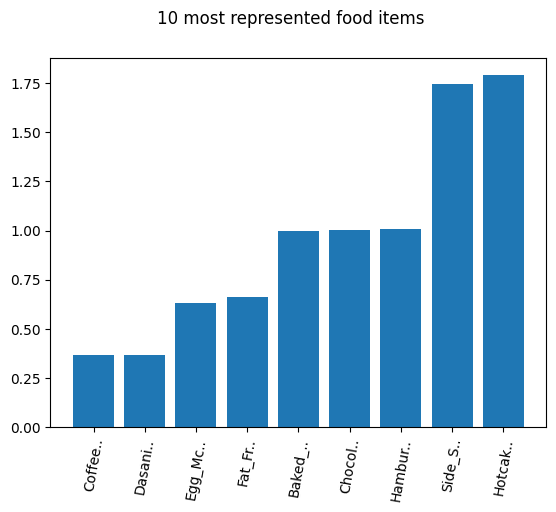

In [151]:
results = solve_full_constraints_pbm(c, n, A, b)
pretty_print_results(*results, n_samples=10)

In [152]:
print(f"Calories totales: {results[2]}")
print("Food of qty > 0.3:")
for item, res, cals in zip(foods['Food'][results[1] >= 0.3], results[1][results[1] >= 0.3], c[results[1] >= 0.3]):
    print(f"  * {item} for ~{res:.2f} items, at {cals} Cals/item, hence ~{res*cals:.2f} Cals")

Calories totales: 1651.6421331297968
Food of qty > 0.3:
  * Baked_Hot_Apple_Pie 2.7_oz_(77_g)                          for ~1.00 items, at 250 Cals/item, hence ~250.00 Cals
  * Chocolate_Chip_Cookie 1_cookie_(33_g)                      for ~1.00 items, at 160 Cals/item, hence ~160.70 Cals
  * Coffee_(Large) 16_fl_oz_cup                                for ~0.37 items, at 0 Cals/item, hence ~0.00 Cals
  * Coffee_(Medium) 16_fl_oz_cup                               for ~0.37 items, at 0 Cals/item, hence ~0.00 Cals
  * Coffee_(Small) 12_fl_oz_cup                                for ~0.37 items, at 0 Cals/item, hence ~0.00 Cals
  * Dasani_Water 16.9_fl_oz                                    for ~0.37 items, at 0 Cals/item, hence ~0.00 Cals
  * Egg_McMuffin 4.8_oz_(135_g)                                for ~0.63 items, at 290 Cals/item, hence ~183.57 Cals
  * Fat_Free_Chocolate_Milk_Jug 1_carton_(236_ml)              for ~0.66 items, at 130 Cals/item, hence ~86.25 Cals
  * Hamburger 3.5_oz_(100

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        This result makes more sense, since now we have a full breakfast and various meals, while not betting everything on some specific meal.
    </p>
    <p>
        Furthermore, even if the total number of calories consumed is higher, we have a better and more various distribution of the meals.
    </p>
</div>

# 3- D'autres problèmes

Beaucoup d'autres problèmes de ce genre existent. Ci-dessous vous trouverez un nouveau problème mais vous êtes également invités à inventer vos propres problèmes et chercher si ils sont solvables par CVXPY ! 

> **Question :** Quels sont les aliments à choisir pour obtenir *au moins* les nutriments recommendés en un minimum d'unités ? 

Status: optimal


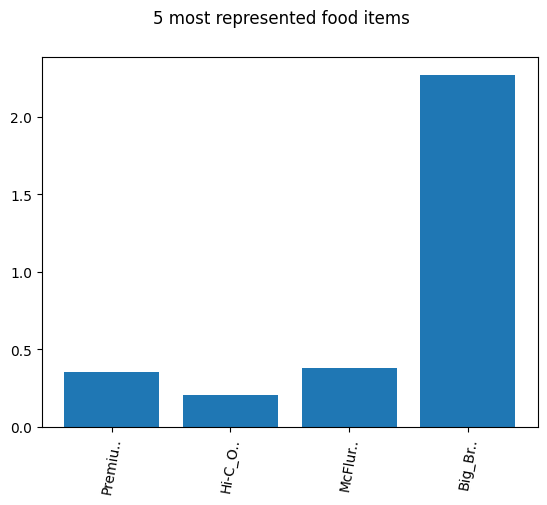

In [159]:
def solve_Q3(c, A, b, n: int):
    x = cp.Variable(n)
    L = cp.sum(x)
    obj = cp.Minimize(L)
    constraints = [x >= 0., A @ x >= b]
    prob = cp.Problem(obj, constraints=constraints)
    prob.solve(solver="ECOS")
    return prob.status, x.value, prob.value

pretty_print_results(*solve_Q3(c, A, b, n))

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        Result: eating fast food is the most efficient way to get calories in the fewest amount of meal.
    </p>
</div>

> **Question :** Quels nutriments sont les plus dur à obtenir (on pourra regarder la valeur de la variable duale) ? 

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <h4><b>What is a dual?</b></h4>
    <p>
        We reformulate the first problem in so-called "standard form", so that the constraints are only equalities:
        $$
        (P)\left\lbrace\begin{array}{lrc}
            \min_{x\in\mathbb{R}_+^n} & c^Tx&\\
            \mbox{s.t.} & & \\
            & Ax + s_1 = b & \\
            & -Ax + s_2= -0.8b & \\
            & x_{73} = 0 & \\
            & x_{248} = 0 & \\
            & \sum_i x_i + s_3 = 10 & \\
            & x_i + s_{4, i} = 2 & \forall i\le n \\
            & -\sum_{i\in\{3,\dots,22\}}x_i + s_5  = -1 \\
            x_i \ge 0 & & \\
            s_k \ge 0 & &
        \end{array}\right.
        $$
    </p>
    <p>
        This can be expressed in a more compact form:
        $$
        (P')\left\lbrace\begin{array}{lrc}
            \min_{\tilde{x}\in\mathbb{R}_+^n} & \tilde{c}^T\tilde{x_s}&\\
            \mbox{s.t.} & & \\
            & \tilde{A}\tilde{x_s}=\tilde{b} & \\
        \end{array}\right.
        $$
        With:
        $
        \tilde{A}:=\left[\begin{array}{ccccc}
            A & \vec{1} & \vec{0} & 0 & \vec{0} & \vec{0} \\
            \hline
            -A & \vec{0} & \vec{1} & 0 & \vec{0} & \vec{0} \\
            \hline
            \delta_{i=73} & \vec{0} & \vec{0} & 0 & \vec{0} & \vec{0} \\
            \delta_{i=248} & \vec{0} & \vec{0} & 0 & \vec{0} & \vec{0} \\
            \vec{1} & \vec{0} & \vec{0} & 1 & \vec{0} & \vec{0} \\
            \hline
              & \vec{0} & \vec{0} & 0    &  & \vec{0} \\
            I & \vdots & \vdots & \vdots & I & \vdots \\
              & \vec{0} & \vec{0} & 0    &  & \vec{0} \\
            \hline
            \delta_{i\in\{3,\dots,22\}} & 0 & 0 & 0 & 0 & I
        \end{array}\right]
        $, $
        \tilde{b}:=\left(\begin{array}{c}
            b\\
            -0.8b\\
            0\\
            0\\
            10\\
            \vec{2}\\
            - \vec{1}
        \end{array}\right)$, and $\tilde{x}_s:=\left(\begin{array}{c}x\\\vec{s}\end{array}\right)$, $\tilde{c}:=\left(\begin{array}{c}c\\\vec{0}\end{array}\right)$
    </p>
    <p>
        We would now like to give to each of the constraint (each line) what we call a "Lagrange multiplier", which should measure how important each constraint is.
        A solution of this new problem should be feasible if the original problem is since those coefficients will not change the equalities by being multiplied on both sides.
        Note that we cannot go backward anymore since we do not know the value of those multipliers!
        $$
        (\mbox{constraints})\left\lbrace\begin{array}{l}
            \lambda^T\tilde{A}\tilde{x}_s=\lambda^T\tilde{b} \\
            \lambda \ge 0
        \end{array}\right.
        $$
    </p>
    <p>
        Then, we shall not define those multipliers randomly: they will correspond to the combinations of the nutrients constraints ($\tilde{A}$) bounding $\tilde{c}$ from below, so that $\tilde{A}\lambda\le\tilde{c}$. This clever choice allows us to reformulate:
        $$
        (D)\left\lbrace\begin{array}{lrc}
            \max_{x\in\mathbb{R}_+^n} & \lambda^Tb&\\
            \mbox{s.t.} & & \\
                & \tilde{A}\lambda\le\tilde{c} & \\
            \lambda \ge 0 & &
        \end{array}\right.
        $$
        This is true because minimizing $\tilde{c}^T\tilde{x}_s$ is equivalent to "maximizing its own minimizer", by bellow, which is $\tilde{b}^T\lambda = (\tilde{A}\tilde{x}_s)^T\lambda\le\tilde{c}^Tx$.
    </p>
    So finding the solution of $(D)$ amounts to finding a lower bound for the solution of $(P)$.
</div>

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        The nutrients harder to find are the ones that are over-represented in the dual variable: this means that their associated Lagrange multiplier ("dual variable") is very "active", and so the equality constraint is "hardest to fulfill".
    </p>
</div>

For nutrient Carbo, "activity" is l_i=0.0032
For nutrient Protein, "activity" is l_i=0.0024
For nutrient VitA, "activity" is l_i=0.0109
For nutrient VitC, "activity" is l_i=0.0155


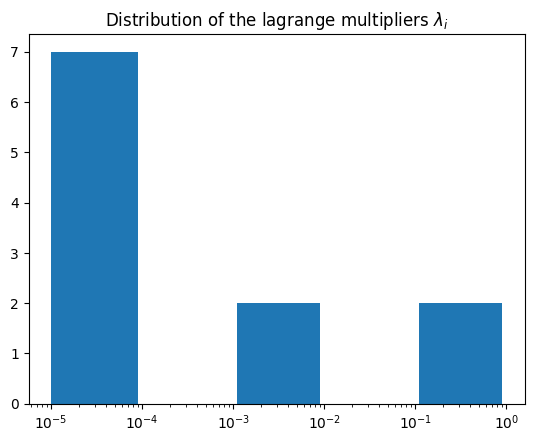

In [184]:
def find_Q3_duals(c, A, b, n: int):
    x = cp.Variable(n)
    L = cp.sum(x)
    obj = cp.Minimize(L)
    constraints = [x >= 0., A @ x >= b]
    prob = cp.Problem(obj, constraints=constraints)
    prob.solve(solver="ECOS")
    return constraints[1].dual_value
lam = find_Q3_duals(c, A, b, n)
for name, l_i in zip(foods.columns, lam):
    if l_i > 1e-5: print(f"For nutrient {name}, \"activity\" is {l_i=:.4f}")
plt.figure()
plt.hist(lam, histtype="bar", bins=[0., 1e-4, 1e-2, 1], rwidth=0.8)
plt.xscale("log")
plt.title(r"Distribution of the lagrange multipliers $\lambda_i$")
plt.show()

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        Here the result is that vitamins are the hardest to get, followed by fat and proteins.
    </p>
</div>

# 4- Programmation entière [*]

Les solutions obtenues précédemment sont des solutions *continues*, alors que l'on commande généralement un nombre entier d'items. Les problèmes d'optimisation avec variables entières appellés (Mixed) Integer Programs, se résolvent avec des méthodes et des solveurs différents. CVXPY appellant différents solveurs nativement, cette opération est transparente ici. 

## Les différences pour la programmation en nombre entier

* le type de la variable qui doit être précisé lors de la déclaration à CVXPY

        x = cp.Variable(n,integer=True) 

* le solver (qui doit etre capable de faire des MIP) (mais c'est transparent pour nous ici)

> **Question:** Reprendre le problème relaxé plus haut (minimisation des calories entre 80% et 100% des contraintes de nutrition) en ajoutant que la variable $x$ est maintenant à valeur entières. Le problème est-il toujours faisable?

In [185]:
def make_mip_loss(calories: np.array, n: int):
    x = cp.Variable(n, integer=True)
    c = calories.squeeze()
    L = c.T @ x
    return L, x

def solve_mip_pbm(calories: np.array, n: int, nutrients: np.array, recomendations: np.array, percentages: tuple[float, float]=(.8, 1.)):
    """
    The problem is to minimize c@x, s.t. x>=0, Ax>=(80%)b, Ax<=(100%)b
    Returns:
        * The solver's final state
        * The problem's sol° x*
        * The loss final value L(x*)
    """
    L, x = make_mip_loss(calories, n)
    obj = cp.Minimize(L)

    constraints = def_box_constraints(x, nutrients, recomendations, percentages)
    prob = cp.Problem(obj, constraints=constraints)
    prob.solve(solver="SCIPY")
    return prob.status, x.value, prob.value

results = solve_mip_pbm(c, n, A, b)
pretty_print_results(*results, n_samples=10)

Status: infeasible
Convergence issues, L(x*)=inf


<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        The problem is now infeasible! It makes sense since the box $0.8\vec{b}\le A\vec{x}\le\vec{b}$ may not contain integer vectors at all depending on $A$ and $\vec{b}$. 
    </p>
</div>

### Relaxation des contraintes

Les problemes MIP (Mixed Integer Programs) sont en général beaucoup plus dur car trouver des points admissibles est difficile.

> **Question :** Relaxez des contraintes jusqu'a obtenir un problème faisable et observez la solution.

Trying combinations
   * 0.79%b <= Ax <= 1.01%b
   * 0.78%b <= Ax <= 1.02%b
   * 0.77%b <= Ax <= 1.03%b
   * 0.76%b <= Ax <= 1.04%b
   * 0.75%b <= Ax <= 1.05%b
###
Found!
Status: optimal


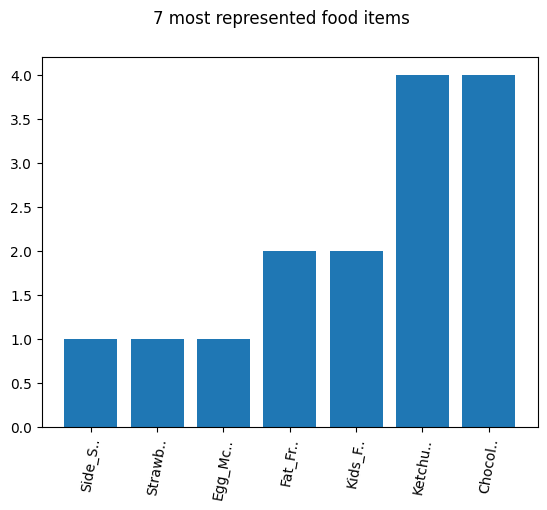

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [202]:
def find_relax_constraints(step=1e-2):
    p_m, p_M = .8, 1.
    results = ('', None, None)
    print("Trying combinations")
    while results[0] != 'optimal':
        p_m -= step
        p_M += step
        print(f'   * {p_m}%b <= Ax <= {p_M}%b')
        results = solve_mip_pbm(c, n, A, b, percentages=(p_m, p_M))
    print("###\nFound!")
    pretty_print_results(*results, n_samples=(results[1] > 0).sum())
    return results, p
results, _ = find_relax_constraints()
print(np.abs(results[1]))

<div class="correction-box" style="background-color: #4CAF50;color: white;padding: 15px;margin: 10px 0;border-radius: 5px;">
    <h3>Correction:</h3>
    <p>
        We are lucky, the solver promoted a rather sparse solution: the total number of food items is ~$15$, so ~$3$ per meal.
    </p>
</div>